# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
from Indicators import Measures, Trend, Volatility, Adjustments
from Fetch_Data import RandomData, CSV
from Results import GraphAdjustments
import seaborn as sns
import inspect

# Extraction du data

In [2]:
# Génération des données simulées
#data, asset_names = RandomData.simulate_asset_prices(n_days=1252, n_assets=1)
# Extraction du data de tradingview
file_path = 'C:\\Users\\noham\\OneDrive\\Bureau\\trading\\base de données\\Algo ETF\\DATA TOT.csv'
data, asset_names = CSV.tradingview(file_path, close_asset_name='SPY',n_assets=1)


Actifs sélectionnés : ['SPY']


# Backtest Core

In [3]:
# Définition des catégories d'indicateurs basées sur le type et la période
indicator_types = ['ROC'
                   , 'WMA_Ratio'
                   , 'EMA_Ratio'
                   , 'SMA_Ratio'
                   , 'Median_Ratio'
                   , 'Donchian_Channels_Ratio'
                   , 'RSI'
                   , 'mode'
                   , 'aroon_Ratio'
                   , 'CTI'
                   , 'adx_Ratio'
                   , 'psych_index'
                   ]


#indicator_types = ['ROC', 'WMA_Ratio', 'EMA_Ratio', 'SMA_Ratio', 'Median_Ratio', 'Donchian_Channels_Ratio','RSI', 'mode', 'aroon_up_down', 'CBTI', 'supertrend_ratio', 'adx_ratio']
trend_periods = [(16, 64), (64, 256)]

# Initialize an empty dictionary to hold signal columns
signals_columns_dict = {}

# Calcul des indicateurs et des signaux
for column in asset_names:
    for lenST, lenLT in trend_periods:
        for indicator_type in indicator_types:
            if indicator_type == 'ROC':
                indicator = Trend.ROC_WMA(data, column, lenST, lenLT) #OK
            elif indicator_type == 'WMA_Ratio':
                indicator = Trend.wmaRatio(data, column, lenST, lenLT) #OK
            elif indicator_type == 'EMA_Ratio':
                indicator = Trend.emaRatio(data, column, lenST, lenLT) #OK
            elif indicator_type == 'SMA_Ratio':
                indicator = Trend.smaRatio(data, column, lenST, lenLT) #OK
            elif indicator_type == 'Median_Ratio':
                indicator = Trend.median_ratio(data, column, lenST, lenLT) #OK
            elif indicator_type == 'Donchian_Channels_Ratio':
                indicator = Trend.donchian_channel_ratio(data, column, lenST, lenLT) #OK
            elif indicator_type == 'RSI':
                indicator = Trend.rsi_wma(data, column, lenST, lenLT) #OK
            elif indicator_type == 'mode':
                indicator = Trend.mode_ratio(data, column, lenST, lenLT) #OK
            elif indicator_type == 'aroon_Ratio':
                indicator = Trend.aroon_ratio(data, column, lenLT) # MOYEN 
            elif indicator_type == 'CTI':
                indicator = Trend.cti(data, column, lenLT) #OK
            elif indicator_type == 'adx_Ratio':
                indicator = Trend.adx_wma(data, column, lenST, lenLT) #OK
            elif indicator_type == 'psych_index':
                indicator = Trend.psych_index(data, column, lenST, lenLT) #OK


            
            # Store the signal data in the dictionary
            signal_col = f'{column}_{indicator_type}_{lenST}_{lenLT}_Signal'
            signals_columns_dict[signal_col] = np.where(indicator >= 0, 1, -1)


# Use pd.concat to add all signal columns
data = pd.concat([data, pd.DataFrame(signals_columns_dict, index=data.index)], axis=1)

# Use the keys of the signals_columns_dict to identify signal columns
signals_columns = list(signals_columns_dict.keys())

# Calcul de la moyenne des signaux et ajout à 'data'
data['Average_Signal'] = data[signals_columns].mean(axis=1)



# Longueurs et multiplicateurs pour le calcul de la HV
lengths = [5, 10, 15, 20, 25]
multipliers = [5, 4, 3, 2, 1]

# Calcul de la HV composite pour chaque actif et calcul de la taille de position HV
for column in asset_names:
    # Appel de la fonction calculate_composite_hv pour calculer la HV composite de l'actif
    data[f'{column}_HV_Composite'] = Volatility.calculate_composite_hv(data, column, lengths, multipliers)
    
    # Calcul de la WMA de la HV
    data[f'{column}_HV_WMA'] = Measures.WMA(data, [f'{column}_HV_Composite'], 20)
    
    # Seuil de HV pour la taille de position maximale
    hv_threshold = 15
    
    # Calcul de la taille de position basée sur la HV
    data[f'{column}_HVPositionSize'] = hv_threshold / data[f'{column}_HV_WMA']


# Équité initiale
initial_equity = 100000  

# Calcul des rendements quotidiens pour chaque actif
daily_returns = data[asset_names].pct_change()

# Calcul des rendements journaliers ajustés par la taille de position HV pour chaque actif
for column in asset_names:
    data[f'{column}_Adjusted_Returns_HV'] = data[column].pct_change() * data[f'{column}_HVPositionSize'].shift(1)

# Regroupement et calcul des rendements ajustés par catégorie d'indicateur pour toutes les périodes
equity_curves = pd.DataFrame(index=data.index)

for indicator_type in indicator_types:
    all_periods_signals = []
    
    for column in asset_names:
        for lenST, lenLT in trend_periods:
            signal_col = f'{column}_{indicator_type}_{lenST}_{lenLT}_Signal'
            adjusted_returns_col = f'{column}_{indicator_type}_{lenST}_{lenLT}_Adjusted_Returns'
            # Utilisation des rendements ajustés par la HV pour les calculs
            data[adjusted_returns_col] = data[signal_col].shift(1) * data[f'{column}_Adjusted_Returns_HV']
            all_periods_signals.append(adjusted_returns_col)
    
    # Ici, au lieu de combiner par période, on combine tous les rendements ajustés pour l'indicateur à travers toutes les périodes
    combined_returns_all_periods = data[all_periods_signals].mean(axis=1)
    equity_curve_label = f'Equity_{indicator_type}_All_Periods'
    equity_curves[equity_curve_label] = (1 + combined_returns_all_periods).cumprod() * initial_equity

# Equity Curves

<function matplotlib.pyplot.show(close=None, block=None)>

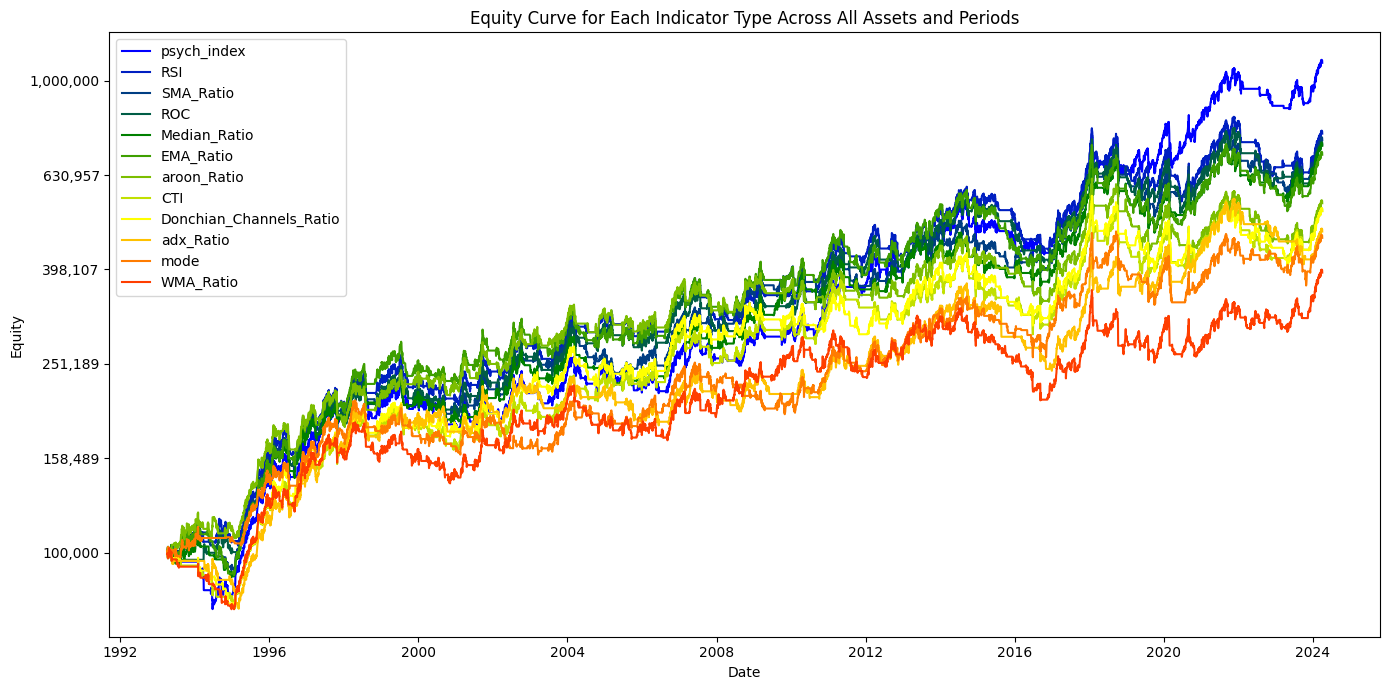

In [4]:
# 1. Calculer les valeurs finales pour chaque courbe d'équité
final_values = equity_curves.iloc[-1]
# 2. Calculer les percentiles des valeurs finales
equity_percentiles = final_values.rank(pct=True)
# Tri des colonnes de equity_curves selon les percentiles
equity_percentiles_sorted_columns = equity_percentiles.sort_values(ascending=False).index

# 3. Définir le colormap
colors = ["red", "yellow", "green", "blue"]  # Définir plus de couleurs si souhaité
cmap_name = 'my_colormap'
colormap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
# 4. Dessiner les courbes d'équité avec coloration basée sur les percentiles
plt.figure(figsize=(14, 7))
for column in equity_percentiles_sorted_columns:
    # Trouver le percentile de la courbe actuelle pour déterminer sa couleur
    perc = equity_percentiles[column]
    color = colormap(perc)
    plt.plot(equity_curves.index, np.log10(equity_curves[column]),  label=column.replace('Equity_', '').replace('_All_Periods', ''), color=color)
plt.title('Equity Curve for Each Indicator Type Across All Assets and Periods')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(GraphAdjustments.log_format))
plt.legend(loc='best')
plt.tight_layout()
plt.show

# tracé de l'indicateur choisi avec entrées et sorties

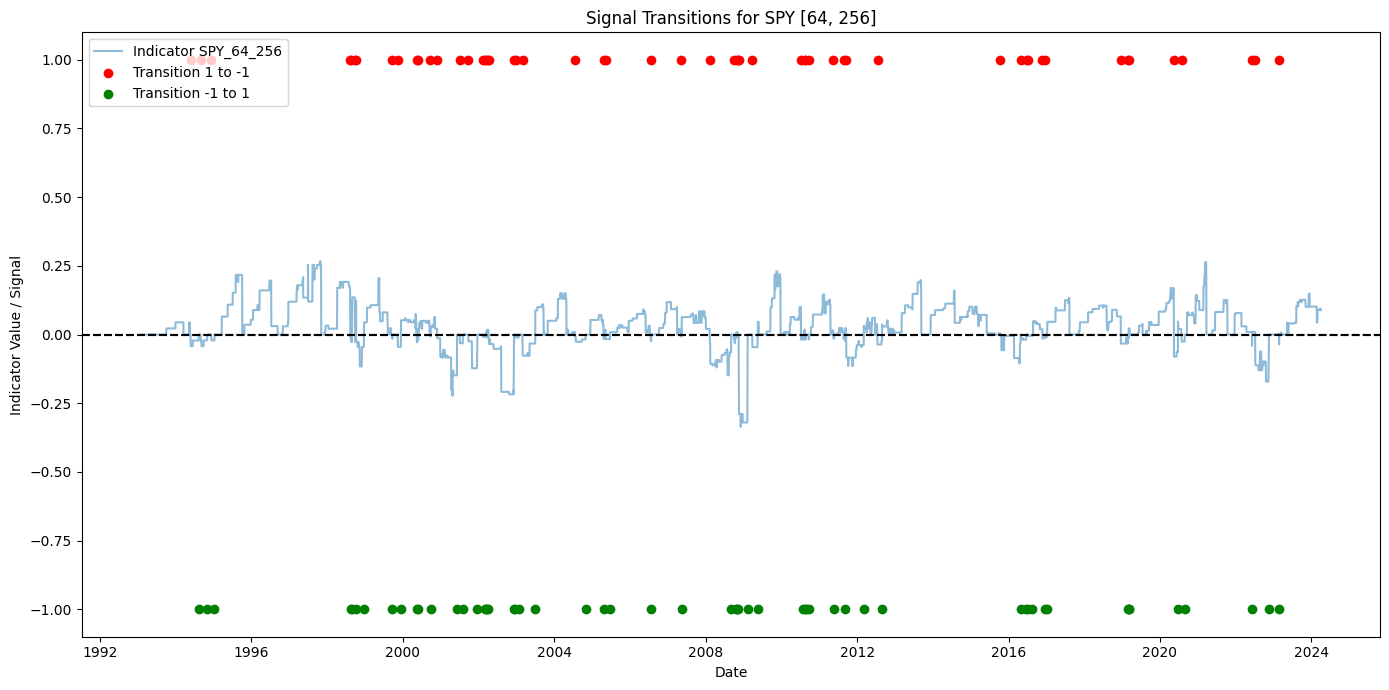

In [5]:
def calcul_et_plot_transitions(data, column, lenST, lenLT):
    indicator_values = Trend.mode_ratio(data, column, lenST, lenLT,0)   #changer l'indicateur qu'on veut check ici
    signals = np.where(indicator_values >= 0, 1, -1)   
    signal_diff = np.diff(signals)   
    # Transitions de 1 à -1
    transitions_down = (signal_diff == -2).nonzero()[0] + 1  
    # Transitions de -1 à 1
    transitions_up = (signal_diff == 2).nonzero()[0] + 1  
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, indicator_values, label=f'Indicator {column}_{lenST}_{lenLT}', alpha=0.5)
    if transitions_down.size > 0:
        plt.scatter(data.index[transitions_down], signals[transitions_down - 1], color='red', label='Transition 1 to -1', zorder=5)
    if transitions_up.size > 0:
        plt.scatter(data.index[transitions_up], signals[transitions_up - 1], color='green', label='Transition -1 to 1', zorder=5)
    
    plt.title(f'Signal Transitions for {column} [{lenST}, {lenLT}]')
    plt.xlabel('Date')
    plt.ylabel('Indicator Value / Signal')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.legend()
    plt.axhline(y=0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()

for column in asset_names:
    calcul_et_plot_transitions(data, column, 64, 256)

# nombre de trades par année pour chaque stratégies

Erreur lors du traitement de SPY, aroon_Ratio, 16, 64: 'numpy.ndarray' object has no attribute 'diff'
Erreur lors du traitement de SPY, aroon_Ratio, 64, 256: 'numpy.ndarray' object has no attribute 'diff'


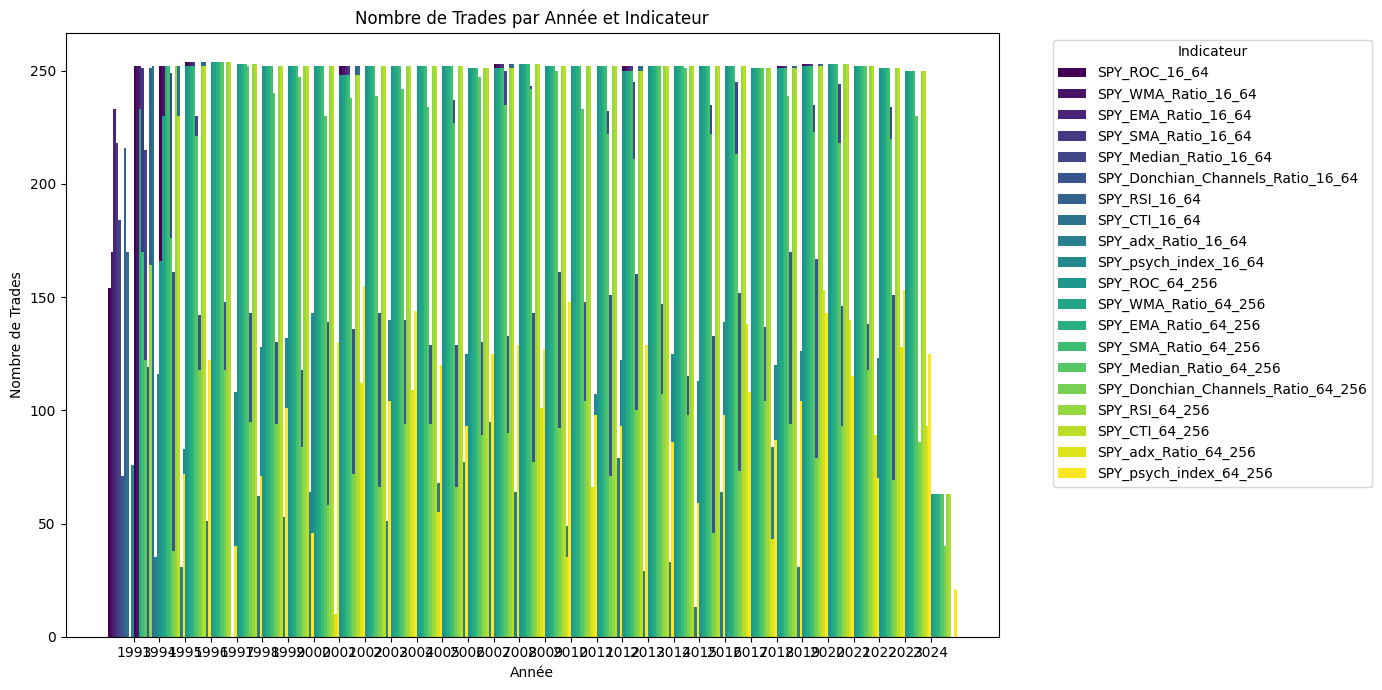

      SPY_ROC_16_64  SPY_WMA_Ratio_16_64  SPY_EMA_Ratio_16_64  \
date                                                            
1993          154.0                170.0                233.0   
1994          252.0                252.0                252.0   
1995          252.0                252.0                252.0   
1996          254.0                254.0                254.0   
1997          253.0                253.0                253.0   

      SPY_SMA_Ratio_16_64  SPY_Median_Ratio_16_64  \
date                                                
1993                218.0                   184.0   
1994                251.0                   215.0   
1995                252.0                   249.0   
1996                254.0                   230.0   
1997                253.0                   241.0   

      SPY_Donchian_Channels_Ratio_16_64  SPY_RSI_16_64  SPY_CTI_16_64  \
date                                                                    
1993                      

In [6]:


indicator_functions = {'ROC' : Trend.ROC_WMA
                   , 'WMA_Ratio' : Trend.wmaRatio
                   , 'EMA_Ratio' : Trend.emaRatio
                   , 'SMA_Ratio' : Trend.smaRatio
                   , 'Median_Ratio' : Trend.median_ratio
                   , 'Donchian_Channels_Ratio' : Trend.donchian_channel_ratio
                   , 'RSI' : Trend.rsi_wma
                   
                   , 'aroon_Ratio' : Trend.aroon_ratio
                   , 'CTI' : Trend.cti
                   , 'adx_Ratio' : Trend.adx_wma
                   , 'psych_index' : Trend.psych_index
                    }

def calcul_trades_annuels(df, columns_to_process, trend_periods, indicator_types, indicator_functions):
    trades_annuels = pd.DataFrame()
    # Boucle à travers chaque colonne (actif) à traiter
    for column in columns_to_process:
        # Boucle à travers chaque combinaison de périodes de tendance
        for lenST, lenLT in trend_periods:
            # Boucle à travers chaque type d'indicateur
            for indicator_type in indicator_types:
                if indicator_type in indicator_functions:  # Vérifier si le type est dans le dictionnaire
                    indicator_function = indicator_functions[indicator_type]
                    # Inspecter le nombre d'arguments requis par la fonction de l'indicateur
                    params = inspect.signature(indicator_function).parameters
                    try:
                        # Appeler la fonction de l'indicateur avec les arguments appropriés
                        if len(params) == 3:
                            indicator_values = indicator_function(df, column, lenLT)
                        elif len(params) == 4:
                            indicator_values = indicator_function(df, column, lenST, lenLT)
                        else:
                            continue  # Ignorer si le nombre de paramètres ne correspond pas                        
                        # Identifier les changements de signe comme "trades"
                        sign_changes = indicator_values.diff().apply(np.sign)  # Calculer les changements de direction
                        trades = sign_changes.abs()  # Un changement de signe implique un trade                       
                        # Ajouter les résultats au DataFrame
                        col_name = f"{column}_{indicator_type}_{lenST}_{lenLT}"
                        trades_annuels[col_name] = trades.groupby(trades.index.year).sum()  # Somme par année

                    except Exception as e:
                        print(f"Erreur lors du traitement de {column}, {indicator_type}, {lenST}, {lenLT}: {e}")
                        continue

    return trades_annuels

def graphique_trades_annuels_2d(trades_annuels):
    n_indicators = len(trades_annuels.columns)
    bar_width = 0.1
    colors = plt.cm.viridis(np.linspace(0, 1, n_indicators))
    plt.figure(figsize=(14, 7))
    indices = np.arange(len(trades_annuels.index))
    for i, (indicator, color) in enumerate(zip(trades_annuels.columns, colors)):
        offset = (i - n_indicators / 2) * bar_width + bar_width / 2
        positions = indices + offset
        plt.bar(positions, trades_annuels[indicator], width=bar_width, label=indicator, color=color)

    plt.xlabel('Année')
    plt.ylabel('Nombre de Trades')
    plt.title('Nombre de Trades par Année et Indicateur')
    plt.xticks(indices, trades_annuels.index)
    plt.legend(title='Indicateur', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation:
trade = calcul_trades_annuels(data, asset_names, trend_periods, indicator_types, indicator_functions)
graphique_trades_annuels_2d(trade)
print(trade.head())

# comparer indicateurs par trades sur toute les années et trend periods

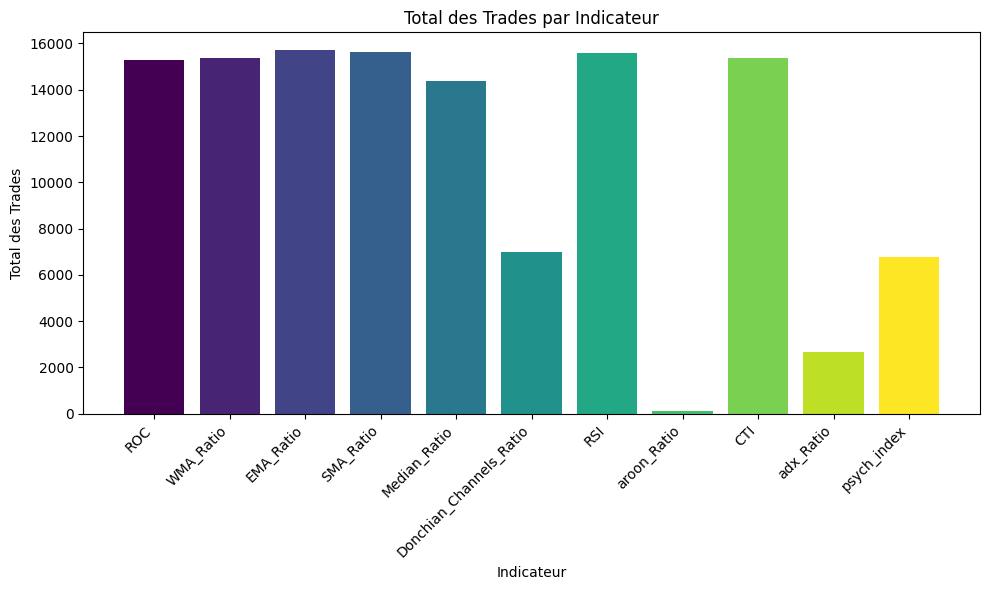

              Total Trades
ROC                15298.0
WMA_Ratio          15378.0
EMA_Ratio          15696.0
SMA_Ratio          15617.0
Median_Ratio       14399.0


In [16]:
def calcul_trades_annuels_agreges(df, columns_to_process, trend_periods, indicator_types, indicator_functions):
    total_trades_par_indicateur = {}

    for column in columns_to_process:
        for lenST, lenLT in trend_periods:
            for indicator_type in indicator_types:
                if indicator_type in indicator_functions:
                    indicator_function = indicator_functions[indicator_type]
                    params = inspect.signature(indicator_function).parameters
                    try:
                        if len(params) == 3:
                            indicator_values = indicator_function(df, column, lenLT)
                        elif len(params) == 4:
                            indicator_values = indicator_function(df, column, lenST, lenLT)
                        else:
                            continue

                        # Convertir les valeurs de l'indicateur en série pandas si ce n'est pas déjà le cas
                        if isinstance(indicator_values, np.ndarray):
                            indicator_values = pd.Series(indicator_values, index=df.index)
                        
                        sign_changes = indicator_values.diff().apply(np.sign)
                        trades = sign_changes.abs()
                        
                        # Aggrégation des trades pour l'indicateur
                        if indicator_type in total_trades_par_indicateur:
                            total_trades_par_indicateur[indicator_type] += trades.sum()
                        else:
                            total_trades_par_indicateur[indicator_type] = trades.sum()

                    except Exception as e:
                        print(f"Erreur lors du traitement de {column}, {indicator_type}, {lenST}, {lenLT}: {e}")
                        continue

    # Convertir en DataFrame pour une manipulation facile plus tard
    total_trades_df = pd.DataFrame.from_dict(total_trades_par_indicateur, orient='index', columns=['Total Trades'])
    return total_trades_df

def graphique_trades_indicateurs(total_trades_df):
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(total_trades_df)))
    
    # Créer un graphique à barres
    plt.bar(total_trades_df.index, total_trades_df['Total Trades'], color=colors)
    
    plt.xlabel('Indicateur')
    plt.ylabel('Total des Trades')
    plt.title('Total des Trades par Indicateur')
    plt.xticks(rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

# Supposons que `data`, `asset_names`, `trend_periods`, et `indicator_types` sont déjà définis.
total_trades = calcul_trades_annuels_agreges(data, asset_names, trend_periods, indicator_types, indicator_functions)
graphique_trades_indicateurs(total_trades)
print(total_trades.head())



# nombre total de trades par années

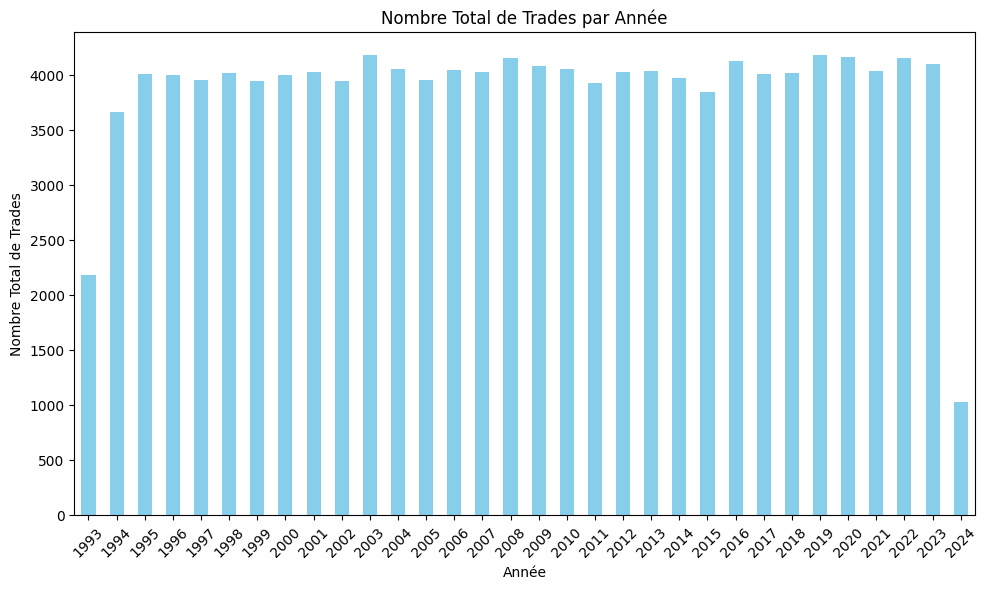

date
1993    2181.0
1994    3663.0
1995    4009.0
1996    4001.0
1997    3951.0
dtype: float64


In [8]:
def calcul_total_trades_annuels(trades_per_year_df):
    # Somme de tous les trades par année, indépendamment des indicateurs
    total_trades_annuels = trades_per_year_df.sum(axis=1)
    return total_trades_annuels


def graphique_total_trades_annuels(total_trades_annuels):
    plt.figure(figsize=(10, 6))
    total_trades_annuels.plot(kind='bar', color='skyblue')
    plt.title('Nombre Total de Trades par Année')
    plt.xlabel('Année')
    plt.ylabel('Nombre Total de Trades')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Assurez-vous que `trades_per_year_df` est la DataFrame retournée par `calcul_trades_annuels`
total_trades_annuels = calcul_total_trades_annuels(trade)
total_trades_annuels.index = total_trades_annuels.index.map(str)  # Convertir l'index en str si nécessaire


# Visualiser les totaux annuels dans un graphique à barres
graphique_total_trades_annuels(total_trades_annuels)

print(total_trades_annuels.head())



# Correlation Matrix

Text(0.5, 1.0, 'Matrice de Corrélation des Rendements des Equity Curves')

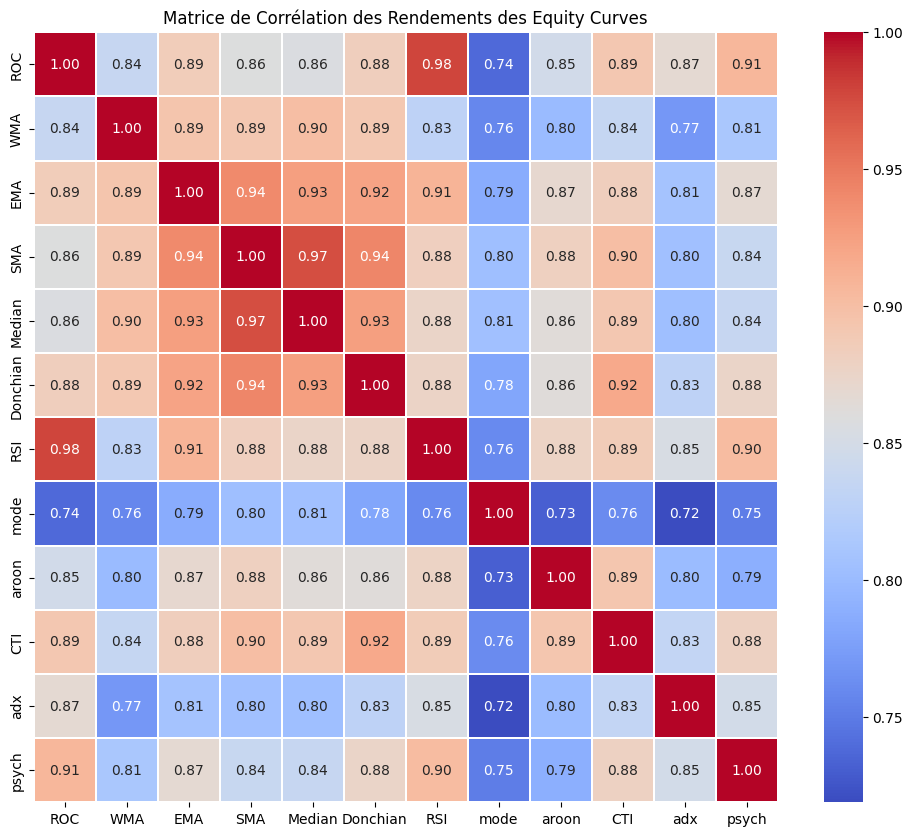

In [10]:
# Extraction des noms simplifiés des indicateurs à partir des noms de colonnes
# Le format est 'Equity_{NomIndicateur}_All_Periods'
simplified_labels = [label.split('_')[1] for label in equity_curves.columns]
# Calcul des rendements quotidiens pour chaque equity curve
equity_returns = equity_curves.pct_change()
# Calcul de la matrice de corrélation pour ces rendements
correlation_matrix = equity_returns.corr()
# Affichage de la heatmap avec les labels simplifiés
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05, xticklabels=simplified_labels, yticklabels=simplified_labels)
plt.title('Matrice de Corrélation des Rendements des Equity Curves')

# Average Correlation Histogram

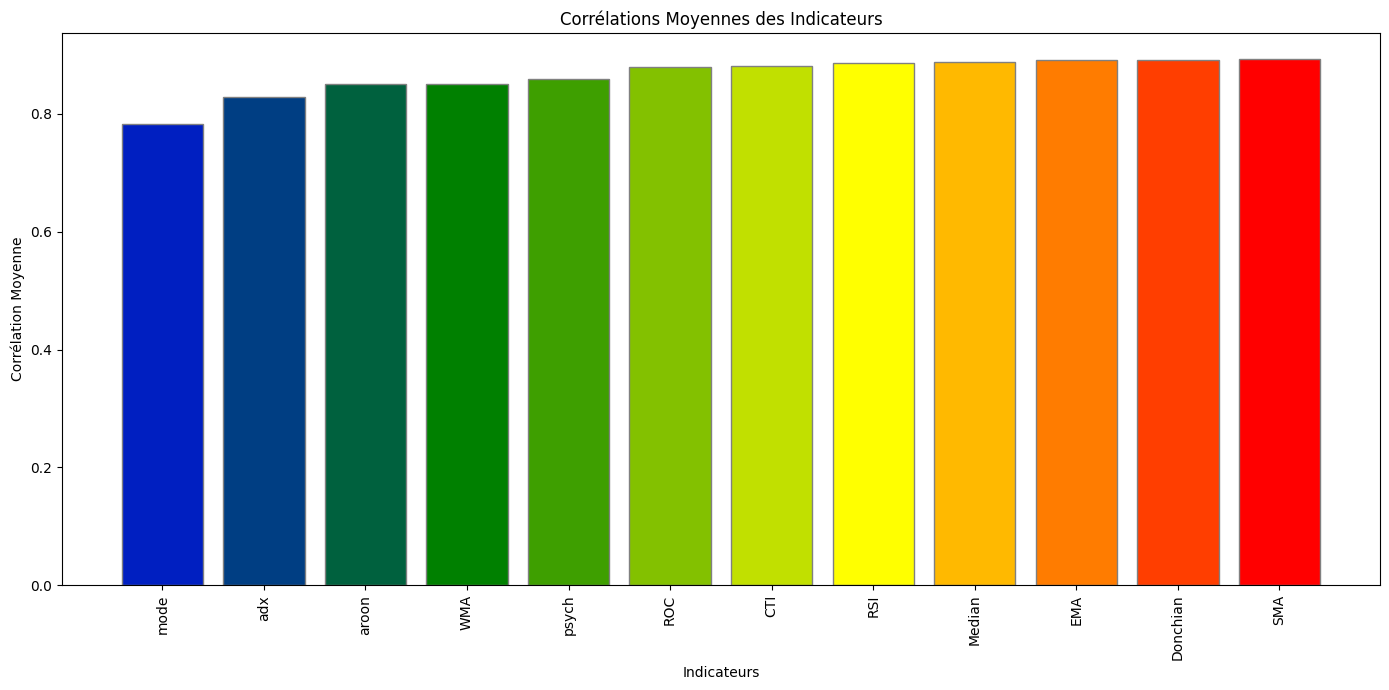

In [11]:
# Calculer la moyenne des corrélations pour chaque indicateur
correlation_means = correlation_matrix.mean()
# Calculer les percentiles pour chaque moyenne de corrélation
percentiles = correlation_means.rank(pct=True)
# Extraire et simplifier les labels des indicateurs
simplified_labels = [label.split('_')[1] for label in correlation_means.index]
# Tri des indicateurs par leurs percentiles pour l'ordre des barres
sorted_indices = percentiles.argsort()
sorted_means = correlation_means.iloc[sorted_indices]
sorted_labels = [simplified_labels[i] for i in sorted_indices]
sorted_percentiles = percentiles.iloc[sorted_indices]
# Définition des couleurs aux extrêmes et création de la LinearSegmentedColormap
colors = ["blue", "green", "yellow", "red"]
cmap_name = 'quantile_cmap'
quantile_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)  # Utiliser 100 pour une transition plus douce



# Création de la figure et des axes
plt.figure(figsize=(14, 7))  # Définir la taille de la figure
# Créer l'histogramme vertical avec les couleurs basées sur les percentiles
for i, (mean, perc) in enumerate(zip(sorted_means, sorted_percentiles)):
    plt.bar(i, mean, color=quantile_cmap(perc), edgecolor='grey')

plt.xticks(range(len(sorted_labels)), sorted_labels, rotation=90)  # Définir les labels des abscisses et leur rotation
plt.xlabel('Indicateurs')  # Label de l'axe des abscisses
plt.ylabel('Corrélation Moyenne')  # Label de l'axe des ordonnées
plt.title('Corrélations Moyennes des Indicateurs')  # Titre du graphique
plt.tight_layout()  # Ajuster automatiquement les paramètres de la figure pour donner un padding adéquat

plt.show()  # Afficher le graphique

# Rollings Returns

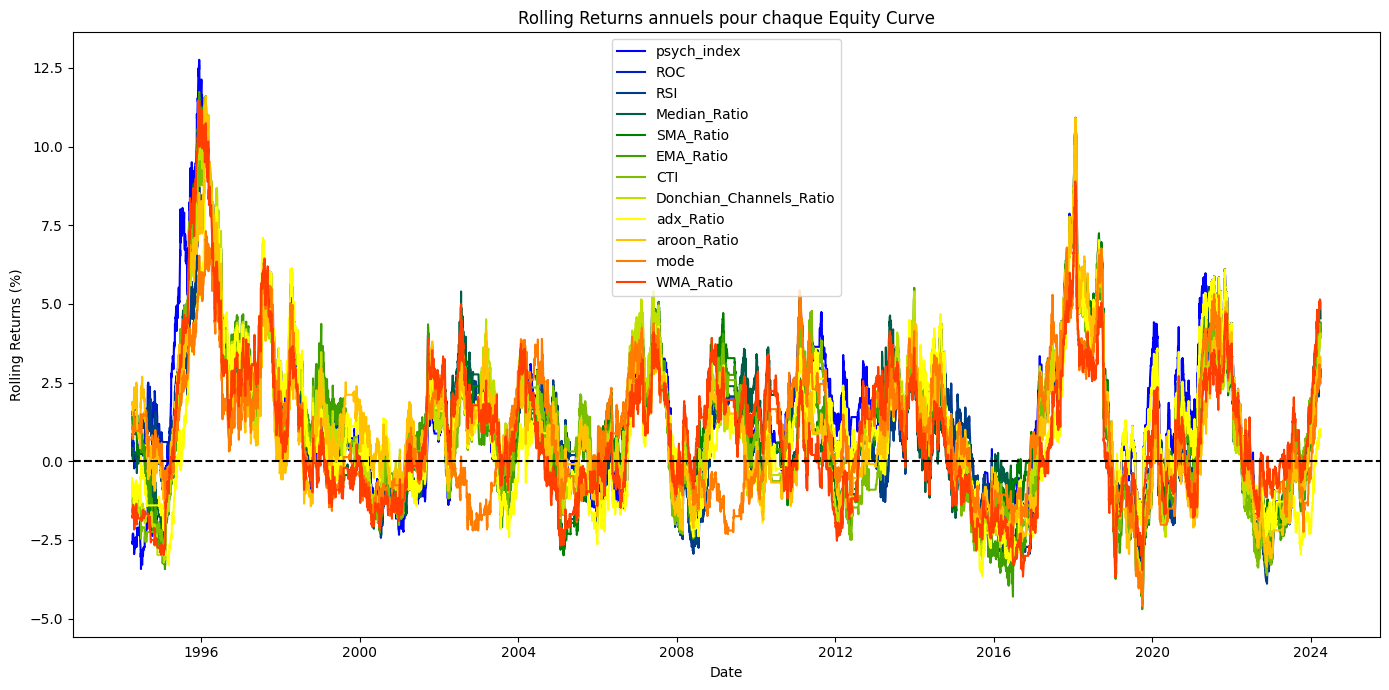

In [12]:
# Création d'un DataFrame vide pour les données de graphique (rolling returns)
plot_data = pd.DataFrame(index=equity_curves.index)

# Calcul des Rolling Returns
rolling_returns_columns = []  # Liste pour les noms des colonnes de rolling returns
for column in equity_curves.columns:
    new_column_name = f'{column}_Rolling_Returns'
    plot_data[new_column_name] = equity_curves[column].pct_change(periods=Adjustments.TRADING_DAYS_PER_YEAR) * Adjustments.ANNUALIZATION_FACTOR
    rolling_returns_columns.append(new_column_name)

# Calcul des Percentiles des Moyennes
rolling_returns_means = plot_data[rolling_returns_columns].mean()
rolling_returns_percentiles = pd.Series(rolling_returns_means).rank(pct=True)

# Trier les percentiles dans un ordre décroissant pour déterminer l'ordre de tracé
sorted_rolling_returns_percentiles = rolling_returns_percentiles.sort_values(ascending=False).index

# Création de la Color Map
colors = ["red", "yellow", "green", "blue"]
cmap_name = 'rolling_returns_colormap'
colormap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# Graphique des Rolling Returns
plt.figure(figsize=(14, 7))
for column in sorted_rolling_returns_percentiles:
    # Trouver le percentile de la colonne pour déterminer sa couleur
    perc = rolling_returns_percentiles[column]
    color = colormap(perc)
    plt.plot(plot_data.index, plot_data[column], label=column.replace('Equity_', '').replace('_All_Periods_Rolling_Returns', ''), color=color)

plt.title('Rolling Returns annuels pour chaque Equity Curve')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Rolling Returns (%)')
plt.legend(loc='best')
plt.tight_layout()

# Drawdowns

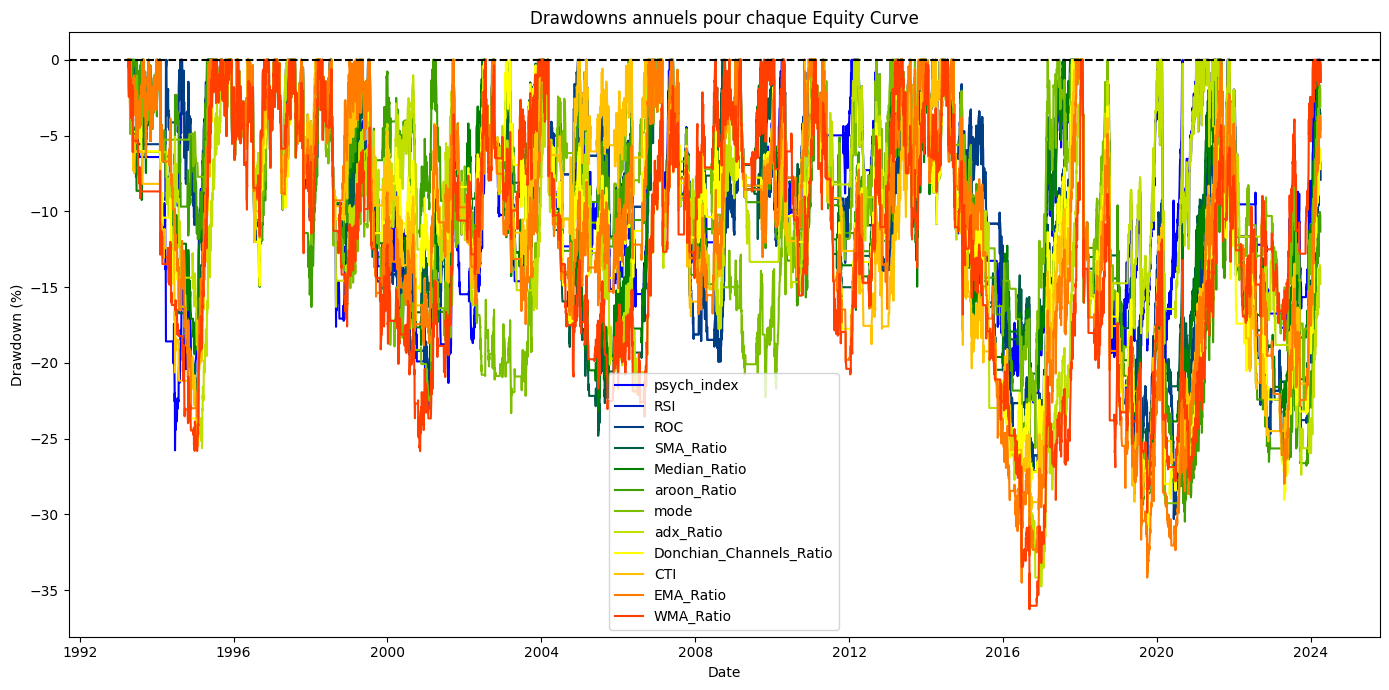

In [13]:
# Calcul des drawdowns

drawdown_columns = []

for column in equity_curves.columns:
    new_column_name = f'{column}_Drawdown'
    max_cumulative = equity_curves[column].cummax()
    plot_data[new_column_name] = 100 * (equity_curves[column] - max_cumulative) / max_cumulative
    drawdown_columns.append(new_column_name)

# Calcul des moyennes de drawdown et des percentiles
drawdown_means = {column: plot_data[column].mean() for column in drawdown_columns}

drawdown_percentiles = pd.Series(drawdown_means).rank(pct=True)

# Trier les colonnes selon les percentiles dans un ordre décroissant
sorted_drawdown_percentiles = drawdown_percentiles.sort_values(ascending=False).index

# Création de la Color Map
colors = ["red", "yellow", "green", "blue"]
colormap = LinearSegmentedColormap.from_list('drawdown_colormap', colors, N=100)

plt.figure(figsize=(14, 7))
for column in sorted_drawdown_percentiles:
    perc = drawdown_percentiles[column]
    color = colormap(perc)
    plt.plot(plot_data.index, plot_data[column], label=column.replace('Equity_', '').replace('_All_Periods_Drawdown', ''), color=color)

plt.title('Drawdowns annuels pour chaque Equity Curve')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

# Sharpe Ratio

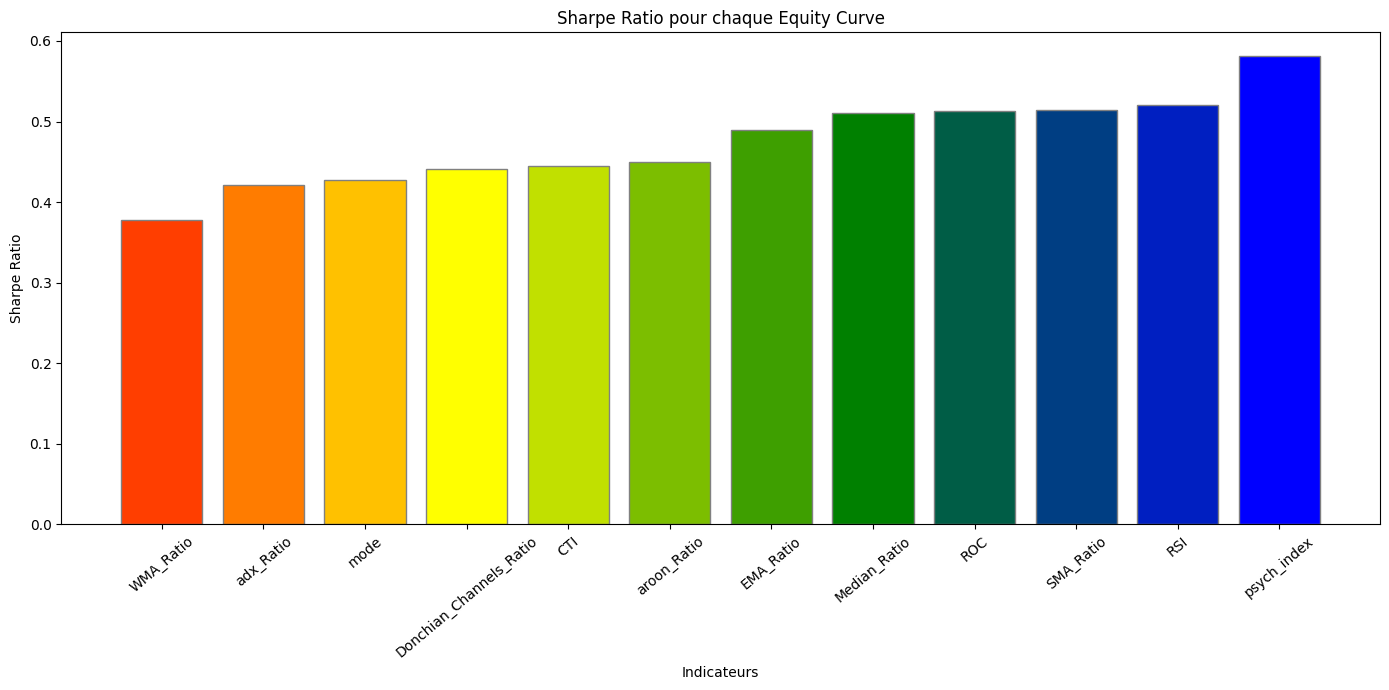

In [14]:
# Calcul du Sharpe Ratio pour chaque courbe d'équité
sharpe_ratios = equity_returns.mean() / equity_returns.std() * Adjustments.ANNUALIZATION_FACTOR

# Calcul des percentiles pour les Sharpe Ratios
percentiles = sharpe_ratios.rank(pct=True)

# Tri des Sharpe Ratios par leurs percentiles pour l'ordre des barres
sorted_indices = percentiles.argsort()
sorted_sharpes = sharpe_ratios.iloc[sorted_indices]
sorted_labels = [sharpe_ratios.index[i] for i in sorted_indices]
sorted_percentiles = percentiles.iloc[sorted_indices]

# Définition des couleurs aux extrêmes et création de la LinearSegmentedColormap
colors = ["red", "yellow", "green", "blue"]
cmap_name = 'sharpe_cmap'
sharpe_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)


plt.figure(figsize=(14, 7))
# Créer l'histogramme vertical avec les couleurs basées sur les percentiles
for i, (sharpe, perc) in enumerate(zip(sorted_sharpes, sorted_percentiles)):
    label_modified = sorted_labels[i].replace('Equity_', '').replace('_All_Periods', '')
    plt.bar(i, sharpe, color=sharpe_cmap(perc), edgecolor='grey', label=label_modified)

plt.xticks(range(len(sorted_labels)), [label.replace('Equity_', '').replace('_All_Periods', '') for label in sorted_labels], rotation=40)
plt.title('Sharpe Ratio pour chaque Equity Curve')
plt.xlabel('Indicateurs')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()